In [1]:
%pip install hcp_utils

Note: you may need to restart the kernel to use updated packages.


In [2]:
import nibabel as nib
import nilearn.plotting as plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import hcp_utils as hcp

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [4]:
#replace with your own path to the data
path='/Users/jtu/Downloads/HCP7T_retino/tfMRI_RETCCW_7T_AP.dtseries.nii'
img = nib.load(f'{path}')
X = img.get_fdata()
X.shape    

(300, 91282)

In [5]:
hcp.struct.keys()
for key in hcp.struct.keys():
    print(f'{key},{hcp.struct[key]}')

cortex_left,slice(0, 29696, None)
cortex_right,slice(29696, 59412, None)
cortex,slice(0, 59412, None)
subcortical,slice(59412, None, None)
accumbens_left,slice(59412, 59547, None)
accumbens_right,slice(59547, 59687, None)
amygdala_left,slice(59687, 60002, None)
amygdala_right,slice(60002, 60334, None)
brainStem,slice(60334, 63806, None)
caudate_left,slice(63806, 64534, None)
caudate_right,slice(64534, 65289, None)
cerebellum_left,slice(65289, 73998, None)
cerebellum_right,slice(73998, 83142, None)
diencephalon_left,slice(83142, 83848, None)
diencephalon_right,slice(83848, 84560, None)
hippocampus_left,slice(84560, 85324, None)
hippocampus_right,slice(85324, 86119, None)
pallidum_left,slice(86119, 86416, None)
pallidum_right,slice(86416, 86676, None)
putamen_left,slice(86676, 87736, None)
putamen_right,slice(87736, 88746, None)
thalamus_left,slice(88746, 90034, None)
thalamus_right,slice(90034, None, None)


In [6]:
X_hipL = X[:, hcp.struct.cortex_left]
# truncated response data, limited to left cortex
print(X_hipL.shape) # (300,29696), matches glasser data

(300, 29696)


In [7]:
import pandas as pd
glasser_labels = pd.read_csv('Glasser.csv', header=None)

In [8]:
glasser_filename="~/Downloads/Q1-Q6_RelatedParcellation210.L.CorticalAreas_dil_Colors.32k_fs_LR.dlabel.nii"
image=nib.load(f'{glasser_filename}')
glasser_data = image.get_fdata().squeeze()
print(glasser_data.shape)  # (29696, ), left cortex labels confirmed

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(29696,)


In [9]:
glasser_labels.columns = ['Index', 'LabelName']
print(glasser_labels[['Index', 'LabelName']])

     Index                      LabelName
0        1          Primary_visual_cortex
1        2  Medial_superior_temporal_area
2        3              Sixth_Visual_Area
3        4             Second_Visual_Area
4        5              Third_Visual_Area
..     ...                            ...
175    176             Area_STSv_Anterior
176    177                Area_TE1_Middle
177    178              Para-Insular_Area
178    179         Area_Anterior_32_Prime
179    180              Area_Posterior_24

[180 rows x 2 columns]


In [10]:
v1_label = glasser_labels.loc[glasser_labels['LabelName'] == 'Primary_visual_cortex', 'Index'].values[0]
v2_label = glasser_labels.loc[glasser_labels['LabelName'] == 'Second_Visual_Area', 'Index'].values[0]
v3_label = glasser_labels.loc[glasser_labels['LabelName'] == 'Third_Visual_Area', 'Index'].values[0]
print(v1_label, v2_label, v3_label)

1 4 5


In [11]:
v1_voxels = np.where(glasser_data == v1_label)[0]  
v2_voxels = np.where(glasser_data == v2_label)[0]  
v3_voxels = np.where(glasser_data == v3_label)[0]  
print(f"V1 index from {v1_voxels.min()} to {v1_voxels.max()}")
print(f"V2 index from {v2_voxels.min()} to {v2_voxels.max()}")
print(f"V3 index from {v3_voxels.min()} to {v3_voxels.max()}")

V1 index from 55 to 24020
V2 index from 65 to 24087
V3 index from 10127 to 23909


In [12]:
unique_labels = glasser_labels['Index'].values
print(f"Total unique Glasser labels: {len(unique_labels)}\n")

for label_id in unique_labels:
    label_name = glasser_labels.loc[glasser_labels['Index'] == label_id, 'LabelName'].values[0]
    voxel_indices = np.where(glasser_data == label_id)[0]

    if len(voxel_indices) == 0:
        continue  # skip empty ones (some may not appear)

    max_index = voxel_indices.max()
    min_index = voxel_indices.min()
    print(f"{label_name:<35s} -> count: {len(voxel_indices):4d} | min index: {min_index:5d} | max index: {max_index:5d}")

    # Check if any index is >= 29696
    if max_index >= 29696:
        print(f"⚠️  Above 29696! Potentially outside dtseries coverage.\n")

Total unique Glasser labels: 180

Primary_visual_cortex               -> count:  827 | min index:    55 | max index: 24020
Medial_superior_temporal_area       -> count:   75 | min index: 13316 | max index: 21415
Sixth_Visual_Area                   -> count:  110 | min index: 10119 | max index: 24120
Second_Visual_Area                  -> count:  605 | min index:    65 | max index: 24087
Third_Visual_Area                   -> count:  406 | min index: 10127 | max index: 23909
Forth_Visual_Area                   -> count:  305 | min index: 11688 | max index: 22922
Eighth_Visual_Area                  -> count:   66 | min index: 22385 | max index: 22768
Primary_Motor_Cortex                -> count:  790 | min index:  1735 | max index: 18004
Primary_Sensory_Cortex              -> count:  563 | min index:  1724 | max index: 16396
Frontal_Eye_Field                   -> count:  150 | min index:  3378 | max index: 28100
Premotor_Eye_Field                  -> count:   83 | min index: 16477 | max 

In [13]:
v1_mask = np.isin(glasser_data, v1_label)
v2_mask = np.isin(glasser_data, v2_label)
v3_mask = np.isin(glasser_data, v3_label)

In [14]:
import numpy as np

def generate_rotating_wedge_stimulus(n_frames=300,
                                     height=200,
                                     width=200,
                                     visual_field_deg=16.08,
                                     wedge_width_deg=90,
                                     cycle_duration=32,
                                     n_cycles=8,
                                     blank_duration=22,
                                     direction='ccw'):
    """
    Generates a binary stimulus matrix representing a rotating wedge stimulus.

    Parameters:
    - n_frames: total number of frames (TRs), default 300
    - height, width: spatial resolution in pixels
    - visual_field_deg: total size of visual field in degrees (assumed square)
    - wedge_width_deg: angular width of the rotating wedge
    - cycle_duration: seconds per full 360° rotation (1 cycle)
    - n_cycles: number of full cycles
    - blank_duration: seconds of blank at start and end
    - direction: 'ccw' or 'cw' (counterclockwise or clockwise)

    Returns:
    - stimulus: array of shape (n_frames, height, width) with binary apertures
    """
    # Visual field coordinate grid in degrees
    x = np.linspace(-visual_field_deg / 2, visual_field_deg / 2, width)
    y = np.linspace(-visual_field_deg / 2, visual_field_deg / 2, height)
    xv, yv = np.meshgrid(x, y)
    polar_angle = (np.arctan2(yv, xv) * 180 / np.pi) % 360  # 0 to 360

    # TRs
    tr = 1.0
    frames_per_cycle = int(cycle_duration / tr)
    blank_frames = int(blank_duration / tr)
    stimulus = np.zeros((n_frames, height, width))

    # Fill in the rotating wedge frames
    for t in range(blank_frames, n_frames - blank_frames):
        cycle_pos = (t - blank_frames) % frames_per_cycle
        angle = (360 * cycle_pos / frames_per_cycle) % 360
        if direction == 'cw':
            angle = (360 - angle) % 360  # reverse rotation

        angle_diff = (polar_angle - angle + 180) % 360 - 180
        wedge_mask = (np.abs(angle_diff) <= wedge_width_deg / 2)
        stimulus[t][wedge_mask] = 1.0

    return stimulus

# Example usage
stimulus_matrix = generate_rotating_wedge_stimulus()
print(stimulus_matrix.shape)  

(300, 200, 200)


In [15]:
def make_prf_matrix(x0_pix, y0_pix, sigma_pix, height=200, width=200):
    """
    Generate a 2D Gaussian pRF matrix over a 200x200 grid (pixel units).
    
    Parameters:
    - x0_pix, y0_pix: center of the pRF in pixels (0-199)
    - sigma_pix: standard deviation of the Gaussian in pixels
    - height, width: grid size (default 200x200)
    
    Returns:
    - prf: 2D array of shape (height, width)
    """
    x = np.linspace(0, width - 1, width)
    y = np.linspace(0, height - 1, height)
    xv, yv = np.meshgrid(x, y)

    prf = np.exp(-((xv - x0_pix)**2 + (yv - y0_pix)**2) / (2 * sigma_pix**2))
    return prf

In [ ]:
# fmri_file = "./hcp_retino/HCP7T_retino/tfMRI_RETCCW_7T_AP.dtseries.nii"

# # Load the file
# img = nib.load(fmri_file)
# data = img.get_fdata()
# left_cortex_data = data[:, :29696]
# print("Shape of fMRI data:", data.shape)

Shape of fMRI data: (300, 91282)


In [ ]:
# v1_bold = left_cortex_data[:, v1_mask]
# v2_bold = left_cortex_data[:, v2_mask]
# v3_bold = left_cortex_data[:, v3_mask]

NameError: name 'left_cortex_data' is not defined

In [16]:
def simulate_voxel_response(stimulus, prf):
    """
    Simulate a voxel's neural response over time by multiplying the stimulus with a pRF.

    Parameters:
    - stimulus: 3D array of shape (T, H, W), where T = timepoints (TRs)
    - prf: 2D array of shape (H, W), the pRF matrix

    Returns:
    - response: 1D array of shape (T,), predicted neural response over time
    """
    # Dot product over (H, W) for each timepoint
    response = np.tensordot(stimulus, prf, axes=([1, 2], [0, 1]))
    return response

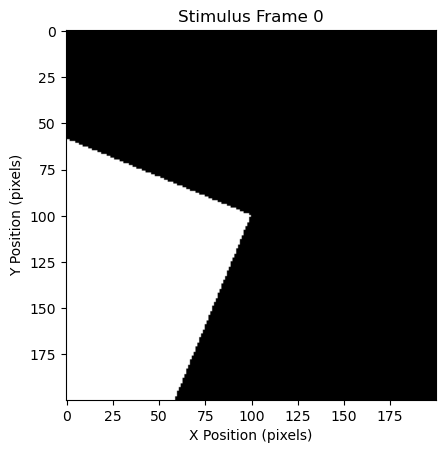

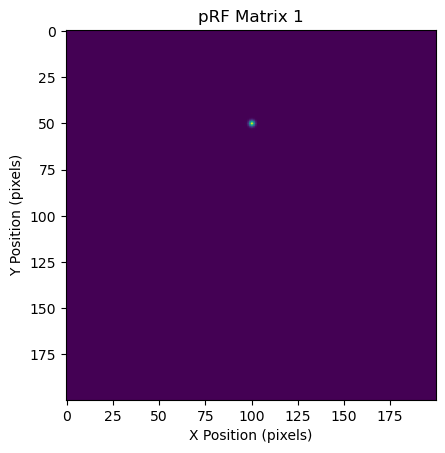

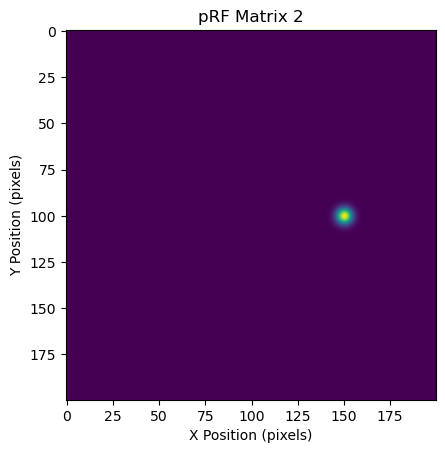

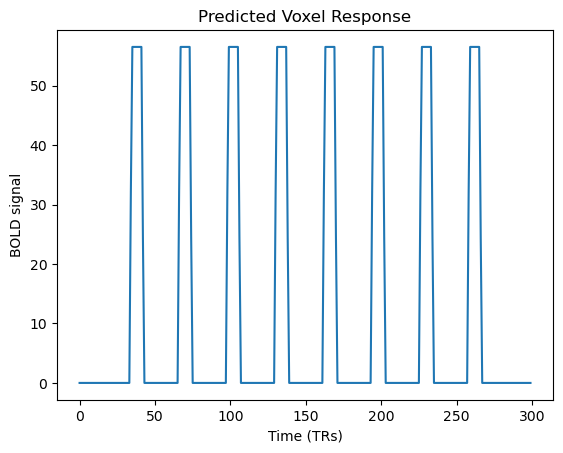

In [17]:
# Example of simulating a voxel response
prf = make_prf_matrix(x0_pix=10, y0_pix=100, sigma_pix=3)
stimulus_matrix=generate_rotating_wedge_stimulus(n_frames=300, height=200, width=200, visual_field_deg=16.08, wedge_width_deg=90, cycle_duration=32, n_cycles=8, blank_duration=22, direction='ccw')
plt.imshow(stimulus_matrix[100], cmap='gray')
plt.title("Stimulus Frame 0")
plt.xlabel("X Position (pixels)")
plt.ylabel("Y Position (pixels)")
plt.show()
plt.imshow(make_prf_matrix(100, 50, 1))
plt.title("pRF Matrix 1")
plt.xlabel("X Position (pixels)")
plt.ylabel("Y Position (pixels)")
plt.show()
plt.imshow(make_prf_matrix(150,100,3))
plt.title("pRF Matrix 2")
plt.xlabel("X Position (pixels)")
plt.ylabel("Y Position (pixels)")
plt.show()
predicted_response = simulate_voxel_response(stimulus_matrix, prf)
import matplotlib.pyplot as plt
plt.plot(predicted_response)
plt.xlabel("Time (TRs)")
plt.ylabel("BOLD signal")
plt.title("Predicted Voxel Response")
plt.show()

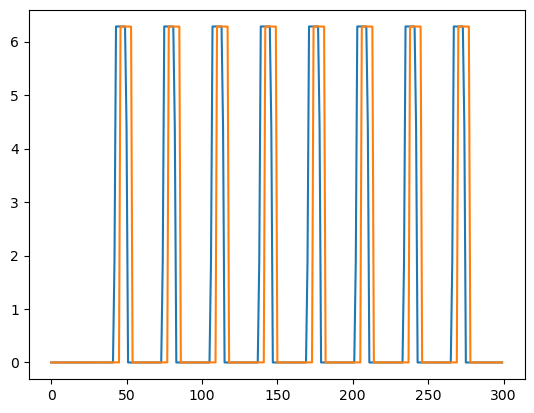

In [18]:
r1 = simulate_voxel_response(stimulus_matrix, make_prf_matrix(100, 50, 1))
r2 = simulate_voxel_response(stimulus_matrix, make_prf_matrix(150, 30, 1))
plt.plot(r1)
plt.plot(r2)

In [19]:
# Select n random V1 voxels
selected_indices_v1 = np.random.choice(v1_voxels, size=5, replace=False)
selected_indices_v2 = np.random.choice(v2_voxels, size=5, replace=False)
selected_indices_v3 = np.random.choice(v3_voxels, size=5, replace=False)
# Extract their BOLD time series
v1_bold_subset = X_hipL[:, selected_indices_v1]
v2_bold_subset = X_hipL[:, selected_indices_v2]
v3_bold_subset = X_hipL[:, selected_indices_v3]
print(X_hipL.shape) # Should be (300, 29696)
print(v1_bold_subset[:,0].shape) # Should be (300,)

(300, 29696)
(300,)


In [23]:
from nilearn.glm.first_level import spm_hrf
from scipy.signal import convolve
import numpy as np

# HRF
hrf = spm_hrf(t_r=1.0,oversampling=1)

# pRF parameter grids
x_grid = np.linspace(0, 199, 30)
y_grid = np.linspace(0, 199, 30)
sigma_grid = np.linspace(5, 10, 10)

# Assume you already have 3 arrays:
# v1_bold_subset, v2_bold_subset, v3_bold_subset
bold_data_dict = {
    'V1': v1_bold_subset,
    'V2': v2_bold_subset,
    'V3': v3_bold_subset
}

# Storage
all_best_params = []
all_best_r2 = []
all_voxel_labels = []

for region_name, bold_subset in bold_data_dict.items():
    print(f"Processing region: {region_name}")
    n_voxels = bold_subset.shape[1]

    for voxel_idx in range(n_voxels):
        bold_ts = bold_subset[:, voxel_idx]
        bold_ts = (bold_ts - np.mean(bold_ts)) / np.std(bold_ts)

        best_score = np.inf
        best_rsq = -np.inf
        best_param = [0, 0, 0]

        for x0 in x_grid:
            for y0 in y_grid:
                for sigma in sigma_grid:
                    prf = make_prf_matrix(x0, y0, sigma)
                    neural_response = simulate_voxel_response(stimulus_matrix, prf)
                    bold_pred = convolve(neural_response, hrf)[:stimulus_matrix.shape[0]]
                    bold_pred = (bold_pred - np.mean(bold_pred)) / np.std(bold_pred)

                    ss_res = np.sum((bold_ts - bold_pred) ** 2)
                    ss_tot = np.sum((bold_ts - np.mean(bold_ts)) ** 2)
                    r2 = 1 - ss_res / ss_tot
                    mse = ss_res / len(bold_ts)

                    if mse < best_score:
                        best_score = mse
                        best_rsq = r2
                        best_param = [x0, y0, sigma]

        all_best_params.append(best_param)
        all_best_r2.append(best_rsq)
        all_voxel_labels.append(region_name)

print("\n=== Grid Search Finished ===\n")

# Print with labels
for i, (params, r2, label) in enumerate(zip(all_best_params, all_best_r2, all_voxel_labels)):
    x, y, sigma = np.round(params[0]), np.round(params[1]), np.round(params[2], 3)
    print(f"Voxel {i:02d} ({label}): x={int(x)}, y={int(y)}, σ={sigma}, R²={r2:.4f}")


Processing region: V1
Processing region: V2
Processing region: V3

=== Grid Search Finished ===

Voxel 00 (V1): x=178, y=27, σ=10.0, R²=-0.7600
Voxel 01 (V1): x=89, y=82, σ=9.444, R²=0.8893
Voxel 02 (V1): x=96, y=82, σ=6.667, R²=0.9258
Voxel 03 (V1): x=96, y=117, σ=6.111, R²=-0.2705
Voxel 04 (V1): x=89, y=89, σ=6.667, R²=0.9080
Voxel 05 (V2): x=124, y=103, σ=10.0, R²=0.3397
Voxel 06 (V2): x=117, y=89, σ=10.0, R²=0.7623
Voxel 07 (V2): x=96, y=82, σ=8.333, R²=0.9059
Voxel 08 (V2): x=110, y=89, σ=8.333, R²=0.8953
Voxel 09 (V2): x=110, y=89, σ=7.222, R²=0.9071
Voxel 10 (V3): x=110, y=89, σ=7.778, R²=0.8948
Voxel 11 (V3): x=110, y=82, σ=9.444, R²=0.9197
Voxel 12 (V3): x=110, y=96, σ=10.0, R²=0.7762
Voxel 13 (V3): x=96, y=82, σ=6.667, R²=0.7338
Voxel 14 (V3): x=130, y=89, σ=10.0, R²=-0.2046


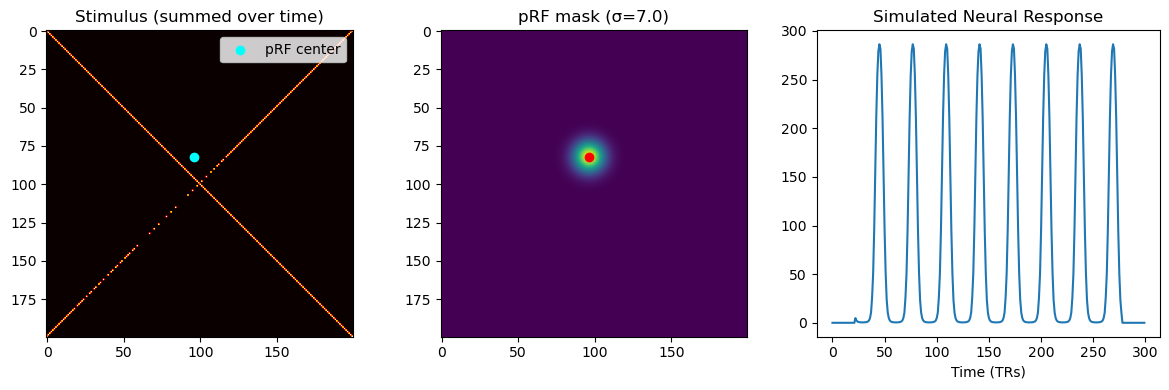

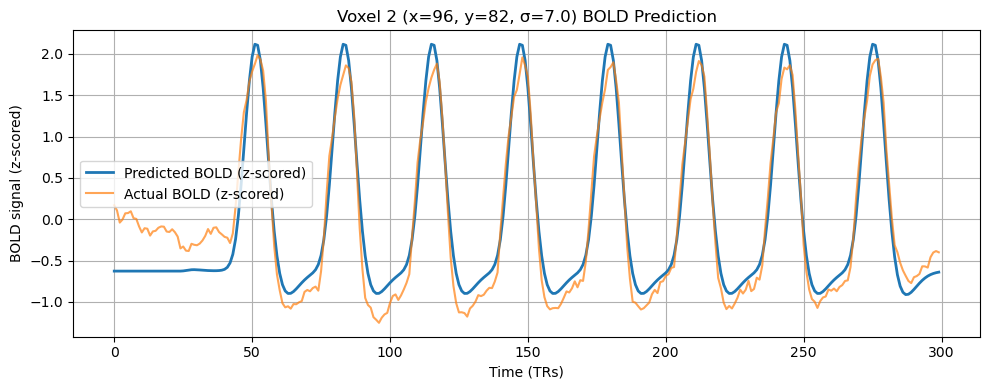

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.glm.first_level import spm_hrf
from scipy.signal import convolve

# 假设你已有 stimulus_matrix, v1_bold_subset, make_prf_matrix, simulate_voxel_response
# 手动设置这个 voxel 的 pRF 参数（来自 grid search）
x0, y0, sigma = 96, 82, 7.0
voxel_index =2   # V1 第三个 voxel

# Step 1: 画出 Stimulus
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(np.sum(stimulus_matrix, axis=0), cmap='hot')
plt.scatter([x0], [y0], color='cyan', label='pRF center')
plt.title("Stimulus (summed over time)")
plt.legend()

# Step 2: pRF mask
prf_mask = make_prf_matrix(x0, y0, sigma)
plt.subplot(1, 3, 2)
plt.imshow(prf_mask, cmap='viridis')
plt.scatter([x0], [y0], color='red')
plt.title(f"pRF mask (σ={sigma})")

# Step 3: 神经响应（未卷积）
neural_response = simulate_voxel_response(stimulus_matrix, prf_mask)

plt.subplot(1, 3, 3)
plt.plot(neural_response)
plt.title("Simulated Neural Response")
plt.xlabel("Time (TRs)")
plt.tight_layout()
plt.show()

# Step 4: HRF 卷积
hrf = spm_hrf(1.0,oversampling=1)

def convolve_hrf(neural_response, hrf):
    # Full convolution (len = len(neural) + len(hrf) - 1)
    full_bold = convolve(neural_response, hrf, mode='full')
    # Shift to compensate for HRF delay (typically ~6s, i.e. index 5~6)
    delay = np.argmax(hrf)  # or hardcode = 5~6 if your HRF always peaks around 5s
    return full_bold[delay:delay+len(neural_response)]

bold_pred = convolve(neural_response, hrf)[:stimulus_matrix.shape[0]]

# Optional z-score
bold_pred_z = (bold_pred - np.mean(bold_pred)) / np.std(bold_pred)
bold_real = v1_bold_subset[:, voxel_index]
bold_real_z = (bold_real - np.mean(bold_real)) / np.std(bold_real)

# Step 5: 比较 predicted vs. real
plt.figure(figsize=(10, 4))
plt.plot(bold_pred_z, label='Predicted BOLD (z-scored)', linewidth=2)
plt.plot(bold_real_z, label='Actual BOLD (z-scored)', linewidth=1.5, alpha=0.7)
plt.title(f"Voxel {voxel_index} (x={x0}, y={y0}, σ={sigma}) BOLD Prediction")
plt.xlabel("Time (TRs)")
plt.ylabel("BOLD signal (z-scored)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [24]:

# 转换为 numpy
params_array = np.array(all_best_params)
r2_array = np.array(all_best_r2)
labels_array = np.array(all_voxel_labels)

# 设定阈值（你也可以调整）
r2_threshold = 0.7
good_indices = np.where(r2_array > r2_threshold)[0]

# 提取高质量样本
good_params = params_array[good_indices]        # shape: (N_good, 3)
good_bold = X_hipL[:, good_indices]             # shape: (300, N_good)
good_labels = labels_array[good_indices]        # optional: V1/V2/V3


In [25]:
# Transpose for neural net input: (N_samples, T)
X_train = good_bold.T           # shape: (N_good, 300)
y_train = good_params           # shape: (N_good, 3)

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

class PRFNet(nn.Module):
    def __init__(self, input_dim=300, hidden_dim=128):
        super(PRFNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 3)  # output: x, y, sigma
        )

    def forward(self, x):
        return self.net(x)

In [28]:
# Prepare tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32)

# Initialize model
model = PRFNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
n_epochs = 200
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_tensor)
    loss = criterion(y_pred, y_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")
model.eval()
with torch.no_grad():
    y_pred = model(X_tensor).numpy()

# 打印前几个 voxel 的预测 vs ground truth
for i in range(min(10, len(y_pred))):
    pred_x, pred_y, pred_sigma = y_pred[i]
    true_x, true_y, true_sigma = y_train[i]
    print(f"Voxel {i:02d}:")
    print(f"  Predicted -> x={pred_x:.1f}, y={pred_y:.1f}, σ={pred_sigma:.2f}")
    print(f"  GroundTruth -> x={true_x:.1f}, y={true_y:.1f}, σ={true_sigma:.2f}")
    print(f"  Δx={abs(pred_x - true_x):.1f}, Δy={abs(pred_y - true_y):.1f}, Δσ={abs(pred_sigma - true_sigma):.2f}")
    print("-" * 40)


Epoch 0: Loss = 141860.4688
Epoch 20: Loss = 34087.0000
Epoch 40: Loss = 2711.9824
Epoch 60: Loss = 366.3781
Epoch 80: Loss = 117.7985
Epoch 100: Loss = 102.9504
Epoch 120: Loss = 95.4932
Epoch 140: Loss = 94.3950
Epoch 160: Loss = 94.1844
Epoch 180: Loss = 94.0993
Voxel 00:
  Predicted -> x=108.8, y=92.6, σ=8.40
  GroundTruth -> x=89.2, y=82.3, σ=9.44
  Δx=19.6, Δy=10.3, Δσ=1.04
----------------------------------------
Voxel 01:
  Predicted -> x=105.8, y=90.6, σ=7.84
  GroundTruth -> x=96.1, y=82.3, σ=6.67
  Δx=9.7, Δy=8.3, Δσ=1.18
----------------------------------------
Voxel 02:
  Predicted -> x=117.0, y=90.1, σ=12.56
  GroundTruth -> x=89.2, y=89.2, σ=6.67
  Δx=27.8, Δy=0.9, Δσ=5.89
----------------------------------------
Voxel 03:
  Predicted -> x=104.1, y=89.5, σ=6.52
  GroundTruth -> x=116.7, y=89.2, σ=10.00
  Δx=12.6, Δy=0.3, Δσ=3.48
----------------------------------------
Voxel 04:
  Predicted -> x=98.7, y=84.5, σ=9.11
  GroundTruth -> x=96.1, y=82.3, σ=8.33
  Δx=2.7, Δy=2.

In [29]:
from scipy.signal import convolve
ground_truth_responses = []
for param in all_best_params:
    prf = make_prf_matrix(*param)
    response = simulate_voxel_response(stimulus_matrix, prf)
    bold = convolve(response, hrf)[:300]
    bold = (bold - np.mean(bold)) / np.std(bold)
    ground_truth_responses.append(bold)

bold_ts_tensor = torch.tensor(np.array(ground_truth_responses), dtype=torch.float32)


In [30]:
import torch
import torch.nn.functional as F

def kl_divergence(p, q, eps=1e-6):
    """
    p, q: shape (batch_size, T)
    KL(P || Q) = sum p(t) * log(p(t)/q(t))
    """
    p = p + eps
    q = q + eps
    kl = p * torch.log(p / q)
    return kl.sum(dim=1).mean()

In [31]:
# 加载 stimulus/HRF
stimulus_tensor = torch.tensor(stimulus_matrix, dtype=torch.float32)  # (T, H, W)
hrf_tensor = torch.tensor(hrf, dtype=torch.float32)  # (L,)

def simulate_prf_bold_batch(params, stimulus, hrf):
    """
    params: (B, 3) — predicted x, y, sigma
    stimulus: (T, H, W)
    hrf: (L,)
    returns: (B, T) — predicted BOLD time series
    """
    B, T, H, W = params.shape[0], stimulus.shape[0], stimulus.shape[1], stimulus.shape[2]
    predicted_bold = []
    for i in range(B):
        x0, y0, sigma = params[i]
        prf = make_prf_matrix(x0.item(), y0.item(), sigma.item())  # numpy
        prf_tensor = torch.tensor(prf, dtype=torch.float32)
        neural_response = torch.tensordot(stimulus, prf_tensor, dims=([1,2],[0,1]))  # (T,)
        bold = F.conv1d(neural_response.view(1,1,-1), hrf.view(1,1,-1))  # (1,1,T+L-1)
        bold = bold[0,0,:T]  # trim to match time
        predicted_bold.append(bold)
    return torch.stack(predicted_bold)

# 模拟 BOLD（batch）
params_pred = model(X_tensor)  # shape: (B, 3)
bold_pred = simulate_prf_bold_batch(params_pred, stimulus_tensor, hrf_tensor)  # (B, T)
bold_true = bold_ts_tensor  # 你需要事先保存的 ground truth

# 可选：z-score
bold_pred = (bold_pred - bold_pred.mean(dim=1, keepdim=True)) / bold_pred.std(dim=1, keepdim=True)
bold_true = (bold_true - bold_true.mean(dim=1, keepdim=True)) / bold_true.std(dim=1, keepdim=True)

# Loss
loss = kl_divergence(bold_true, bold_pred)


RuntimeError: The size of tensor a (300) must match the size of tensor b (269) at non-singleton dimension 1